In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sklearn.manifold as manifold

## Read twitter network and the labels


In [3]:
twi_net=pd.read_csv('twitter.csv')
twi_fakeids=pd.read_csv('twitter_fake_ids.csv')

In [117]:
print('Fake IDs shape=',twi_fakeids.shape)
print('Edge List shape=',twi_net.shape)

Fake IDs shape= (12437, 2)
Edge List shape= (16011444, 2)


In [5]:
twi_net.head()

,src,dst
0,1,2
1,3,4
2,5,6
3,5,7
4,5,8


In [120]:
print('Number of nodes in network=',np.max(twi_net['src']))

Number of nodes in network= 5383302


In [18]:
G=nx.from_pandas_edgelist(twi_net[1:1000],'src','dst')

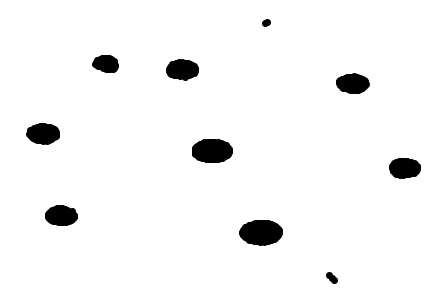

In [19]:
options = {
    'node_color': 'black',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}
nx.draw(G, **options)
plt.show()

# Analysis so far
1. Network is too big. We need to select a subgraph from the network
2. One good thing about the dataset is that the nodes are numbered in order 
3. Selecting the first 1000 entries in the edgelist obviously yields a heavily disconnected graph
4. We need to select a portion of the dataset which includes some fake nodes.


In [20]:
twi_fakeids.head()

,id,label
0,298970,Fake
1,4530349,Fake
2,1410014,Fake
3,2064057,Fake
4,696273,Fake


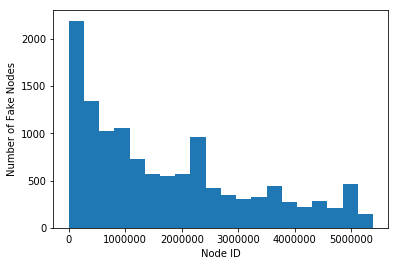

In [121]:
plt.hist(twi_fakeids['id'],20)
plt.xlabel('Node ID')
plt.ylabel('Number of Fake Nodes')
plt.show()

## Clearly, we cannot include all the fake nodes because my computer cannot load this huge graph

## Load the first 5000 source nodes into graph

In [123]:
G=nx.from_pandas_edgelist(twi_net[twi_net['src']<=5000],'src','dst',create_using=nx.DiGraph)

 ## We want to plot some of the real and fake nodes. We choose first hundred nodes and all their neighbours

In [175]:
nnodes=100
plot_nodes=set(range(1,100))
# Get neighbours of all nnodes
for node in range(1,nnodes):
    plot_nodes=plot_nodes.union(set(G[node]))
print('Number of nodes to plot=',len(plot_nodes))

Number of nodes to plot= 18797


In [53]:
#Graph visualization routine
subG=G.subgraph(plot_nodes)
pos=nx.spring_layout(subG)

G:\Miniconda3\envs\general\lib\site-packages\networkx\drawing\layout.py:596: RuntimeWarning: invalid value encountered in sqrt
  distance = np.sqrt((delta**2).sum(axis=0))


In [177]:
print('Number of fake nodes present in plot=',len(plot_nodes.intersection(set(twi_fakeids['id']))))

Number of fake nodes present in plot= 416


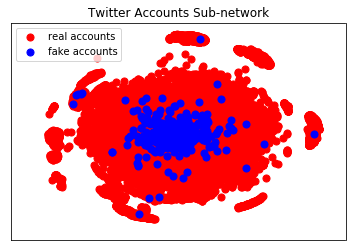

In [82]:
fake_plot_nodes=plot_nodes.intersection(set(twi_fakeids['id']))
real_plot_nodes=plot_nodes-set(twi_fakeids['id'])
nx.draw_networkx_nodes(subG,pos,nodelist=real_plot_nodes,node_color='r',node_size=50, label='real accounts')
nx.draw_networkx_nodes(subG,pos,nodelist=fake_plot_nodes,node_color='b',node_size=50, label='fake accounts')
axes=plt.gca()
axes.set_ylim([-0.15,0.15])
plt.legend()
plt.title('Twitter Accounts Sub-network')
plt.show()

In [124]:
print('Number of nodes in graph G=',G.number_of_nodes())

Number of nodes in graph G= 85067


## Let's look at some node statistics

In [125]:
in_deg=np.array(G.in_degree())
out_deg=np.array((G.out_degree()))
clustering=nx.clustering(G)

In [126]:
node_stat=pd.DataFrame(data={'node_id':in_deg[:,0],'in_degree':in_deg[:,1],'out_degree':out_deg[:,1],'clustering':list(clustering.values())})
node_stat.head()

,node_id,in_degree,out_degree,clustering
0,1,0,1,0.000000
1,2,1,0,0.000000
2,3,0,1,0.000000
3,4,1,0,0.000000
4,5,3,46,0.046888


In [78]:
fake_node_stat=node_stat.iloc[np.where(np.isin(node_stat['node_id'],twi_fakeids['id']))[0]]
real_node_stat=node_stat.iloc[np.where(~np.isin(node_stat['node_id'],twi_fakeids['id']))[0]]

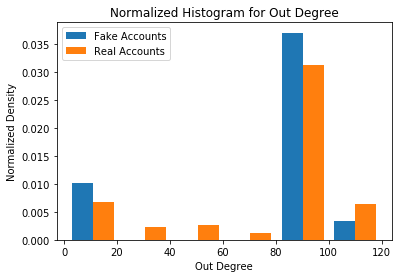

In [77]:
plt.figure()
plt.hist([fake_node_stat['out_degree'],real_node_stat['out_degree']],bins=6, range=(1,120), density=True,label=['Fake Accounts', 'Real Accounts'])
plt.legend()
plt.xlabel('Out Degree')
plt.ylabel('Normalized Density')
plt.title('Normalized Histogram for Out Degree')
plt.show()

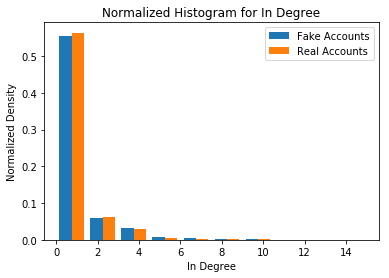

In [78]:
plt.figure()
plt.hist([fake_node_stat['in_degree'],real_node_stat['in_degree']], bins=10, range=(0,15), density=True,label=['Fake Accounts', 'Real Accounts'])
plt.legend()
plt.xlabel('In Degree')
plt.ylabel('Normalized Density')
plt.title('Normalized Histogram for In Degree')
plt.show()

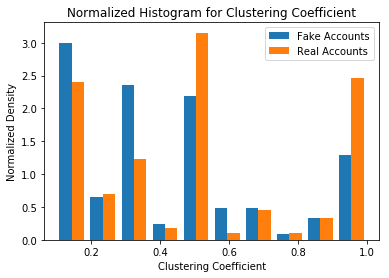

In [84]:
plt.figure()
plt.hist([fake_node_stat['clustering'],real_node_stat['clustering']], bins=10, range=(0.1,1.0), density=True, label=['Fake Accounts', 'Real Accounts'])
plt.legend()
plt.xlabel('Clustering Coefficient')
plt.ylabel('Normalized Density')
plt.title('Normalized Histogram for Clustering Coefficient')
plt.show()

#### It turns out that the Out Degree and Clustering Coefficient distribution is not similar for the real and the fake nodes. Hence, it might be helpful to add them to the embedding vectors 

## Create edgelist for node2vec

In [13]:
twi_net_trimmed=twi_net[twi_net['src']<=5000].copy().reset_index(drop=True)
f = open('twi_net_trimmed.edgelist','w')
for i in range(len(twi_net_trimmed)):
    s = str(twi_net_trimmed['src'][i])
    t = str(twi_net_trimmed['dst'][i])
    f.write(s+' '+t+'\n')
f.close()

## We use Node2Vec, the skipgram based neural network to learn embeddings for the nodes in the graph.

https://github.com/snap-stanford/snap/tree/master/examples/node2vec

We use, embedding size of 128, length of random walk 15, number of random walks 25, epochs 15, p 0.3 and q 1. 

Usage:
./node2vec -i:graph/twi_net_trimmed.edgelist -o:emb/twi_net_trimmed.emb -d:128 -l:15 -r:25 -e:15 -p:0.3 -dr -v

In [79]:
nodes=[]
embeddings=[]
embed_file=open('twi_net_trimmed.emb','r')
#First line contains ['num_nodes' 'embed_dimension']
l=embed_file.readline()
while 1:
    l=embed_file.readline()
    if l=='':
        break
    l=l.strip().split(' ')
    #print(l)
    if l[0]!='0':
        nodes.append((l[0]))
        embeddings.append([l[1:]])
nodes=np.array(nodes).astype(int)
embeddings=np.squeeze(np.array(embeddings).astype(float))


In [82]:
NF=np.zeros((embeddings.shape[0],2))
for idx,node_id in enumerate(nodes):
    NF[idx,:]=node_stat.loc[node_stat['node_id']==node_id][['out_degree','clustering']]

In [83]:
embeddings_ext=np.concatenate((embeddings,NF),axis=1)

In [115]:
embeddings_ext.shape

(14714, 130)

## Standardize the embedding matrices

In [39]:
embeddings=(embeddings-np.mean(embeddings,axis=0))/np.std(embeddings,axis=0)
embeddings_ext=(embeddings_ext-np.mean(embeddings_ext,axis=0))/np.std(embeddings_ext,axis=0)

In [40]:
np.save('node_ids.npy',nodes)
np.save('embeddings.npy',embeddings)
np.save('embeddings_ext.npy',embeddings_ext)

In [41]:
nodes=np.load('node_ids.npy')
embeddings=np.load('embeddings.npy')
embeddings_ext=np.load('embeddings_ext.npy')

## Plot 2D projections of the embeddings

In [127]:
#Get 2D projections of embeddings
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
proj = tsne.fit_transform(embeddings)
np.save('twi_net_trimmed_tSNE_projection.npy',proj)

In [85]:
#Create color data for real and fake nodes
fake_node_i=np.where(np.isin(nodes,twi_fakeids['id']))[0]
real_node_i=np.where(~np.isin(nodes,twi_fakeids['id']))[0]

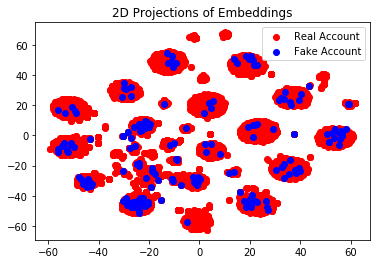

In [98]:
plt.figure()
plt.scatter(proj[real_node_i,0],proj[real_node_i,1],c='r',label='Real Account')
plt.scatter(proj[fake_node_i,0],proj[fake_node_i,1],c='b',label='Fake Account')
plt.legend()
plt.title('2D Projections of Embeddings')
plt.show()

## Make the label vector

In [86]:
labels=np.zeros((nodes.shape))
labels[fake_node_i]=1
print('Minority-Majority ratio = ', sum(labels==1)/len(labels))

Minority-Majority ratio =  0.013592496941688188


## The embedding data is highly imbalanced. We will under sample the majority class and then over sample the minority class

In [87]:
#Under-sample the majority class using Random-sampler
from imblearn.under_sampling import RandomUnderSampler
rus=RandomUnderSampler(sampling_strategy=0.1,random_state=42)
embeddings_us, labels_us=rus.fit_resample(embeddings,labels)
print('Minority-Majority ratio = ', sum(labels_us==1)/sum(labels_us==0))

Minority-Majority ratio =  0.1


In [88]:
#Over-sample the minority class
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=0.4,random_state=42)
embeddings_os, labels_os=smote.fit_resample(embeddings_us,labels_us)
print('Minority-Majority ratio = ', sum(labels_os==1)/sum(labels_os==0))

Minority-Majority ratio =  0.4


## Split data into train and test set

In [89]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(embeddings_os,labels_os,test_size= 0.2,random_state=0)

## Create deep learning model

In [90]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from keras.models import load_model

In [100]:
# Initialize model

input_size = x_train.shape[1] # Features from X matrix

M1 = Sequential()

# Add an input layer
M1.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M1.add(Dense(128, activation='relu'))

# Add second hidden layer
M1.add(Dense(64, activation='relu'))

#Add third hidden layer
M1.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M1.add(Dense(16, activation='relu'))

# Add output layer
M1.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.adam(lr=1e-3)


M1.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=12, verbose=0, mode='min')
check_pointer=keras.callbacks.ModelCheckpoint(filepath='./best_weights.hdf5',verbose=0, monitor='val_loss', mode='min', save_best_only=True)


## Train the model

In [101]:
M1.fit(x_train, y_train, batch_size=16, epochs=200, validation_split=0.2, callbacks=[check_pointer])

Train on 1792 samples, validate on 448 samples
Epoch 1/200
1792/1792 [==============================] - 2s 1ms/step - loss: 0.5779 - acc: 0.7215 - val_loss: 0.5801 - val_acc: 0.7098
Epoch 2/200
1792/1792 [==============================] - 1s 282us/step - loss: 0.5471 - acc: 0.7327 - val_loss: 0.5665 - val_acc: 0.7076
Epoch 3/200
1792/1792 [==============================] - 1s 296us/step - loss: 0.5285 - acc: 0.7360 - val_loss: 0.5956 - val_acc: 0.7098
Epoch 4/200
1792/1792 [==============================] - 0s 274us/step - loss: 0.5210 - acc: 0.7433 - val_loss: 0.5805 - val_acc: 0.7031
Epoch 5/200
1792/1792 [==============================] - 1s 287us/step - loss: 0.5208 - acc: 0.7433 - val_loss: 0.5520 - val_acc: 0.7344
Epoch 6/200
1792/1792 [==============================] - 0s 278us/step - loss: 0.4928 - acc: 0.7662 - val_loss: 0.5598 - val_acc: 0.7455
Epoch 7/200
1792/1792 [==============================] - 1s 282us/step - loss: 0.4651 - acc: 0.7790 - val_loss: 0.5046 - val_acc: 0.7

1792/1792 [==============================] - 1s 300us/step - loss: 0.0364 - acc: 0.9872 - val_loss: 0.4391 - val_acc: 0.9107
Epoch 61/200
1792/1792 [==============================] - 1s 288us/step - loss: 0.0413 - acc: 0.9860 - val_loss: 0.5587 - val_acc: 0.8661
Epoch 62/200
1792/1792 [==============================] - 1s 288us/step - loss: 0.0433 - acc: 0.9872 - val_loss: 0.3268 - val_acc: 0.9062
Epoch 63/200
1792/1792 [==============================] - 1s 282us/step - loss: 0.0650 - acc: 0.9777 - val_loss: 0.3046 - val_acc: 0.9196
Epoch 64/200
1792/1792 [==============================] - 1s 286us/step - loss: 0.0262 - acc: 0.9900 - val_loss: 0.3380 - val_acc: 0.9174
Epoch 65/200
1792/1792 [==============================] - 1s 281us/step - loss: 0.0375 - acc: 0.9860 - val_loss: 0.3438 - val_acc: 0.9174
Epoch 66/200
1792/1792 [==============================] - 1s 286us/step - loss: 0.0251 - acc: 0.9900 - val_loss: 0.3230 - val_acc: 0.9129
Epoch 67/200
1792/1792 [=======================

Epoch 119/200
1792/1792 [==============================] - 1s 282us/step - loss: 1.3803e-05 - acc: 1.0000 - val_loss: 0.4870 - val_acc: 0.9286
Epoch 120/200
1792/1792 [==============================] - 1s 290us/step - loss: 1.2621e-05 - acc: 1.0000 - val_loss: 0.4899 - val_acc: 0.9286
Epoch 121/200
1792/1792 [==============================] - 1s 285us/step - loss: 1.1534e-05 - acc: 1.0000 - val_loss: 0.4910 - val_acc: 0.9286
Epoch 122/200
1792/1792 [==============================] - 1s 292us/step - loss: 1.1018e-05 - acc: 1.0000 - val_loss: 0.5002 - val_acc: 0.9286
Epoch 123/200
1792/1792 [==============================] - 1s 285us/step - loss: 9.9419e-06 - acc: 1.0000 - val_loss: 0.4924 - val_acc: 0.9286
Epoch 124/200
1792/1792 [==============================] - 1s 288us/step - loss: 9.1372e-06 - acc: 1.0000 - val_loss: 0.4984 - val_acc: 0.9286
Epoch 125/200
1792/1792 [==============================] - 1s 285us/step - loss: 8.4115e-06 - acc: 1.0000 - val_loss: 0.5040 - val_acc: 0.9286

Epoch 176/200
1792/1792 [==============================] - 1s 280us/step - loss: 3.2185e-07 - acc: 1.0000 - val_loss: 0.6004 - val_acc: 0.9286
Epoch 177/200
1792/1792 [==============================] - 1s 287us/step - loss: 3.0906e-07 - acc: 1.0000 - val_loss: 0.5992 - val_acc: 0.9286
Epoch 178/200
1792/1792 [==============================] - 1s 280us/step - loss: 2.9385e-07 - acc: 1.0000 - val_loss: 0.6023 - val_acc: 0.9286
Epoch 179/200
1792/1792 [==============================] - 1s 289us/step - loss: 2.8101e-07 - acc: 1.0000 - val_loss: 0.6030 - val_acc: 0.9286
Epoch 180/200
1792/1792 [==============================] - 1s 285us/step - loss: 2.7081e-07 - acc: 1.0000 - val_loss: 0.6046 - val_acc: 0.9286
Epoch 181/200
1792/1792 [==============================] - 1s 289us/step - loss: 2.6071e-07 - acc: 1.0000 - val_loss: 0.6052 - val_acc: 0.9286
Epoch 182/200
1792/1792 [==============================] - 0s 279us/step - loss: 2.4825e-07 - acc: 1.0000 - val_loss: 0.6092 - val_acc: 0.9286

## Test the model and look at some results

In [98]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [102]:
M1=load_model('best_weights.hdf5')
y_pred = M1.predict(x_test)

# Print classfication report
target_names = ['Real Account','Fake Account']
confusion_matrix = cm(y_test, np.round(y_pred))
print("Classification Report")
print(classification_report(y_test, np.round(y_pred), target_names=target_names))

Classification Report
              precision    recall  f1-score   support

Real Account       0.94      0.95      0.94       389
Fake Account       0.88      0.87      0.87       171

    accuracy                           0.92       560
   macro avg       0.91      0.91      0.91       560
weighted avg       0.92      0.92      0.92       560



Normalized confusion matrix
[[0.94601542 0.05398458]
 [0.12865497 0.87134503]]


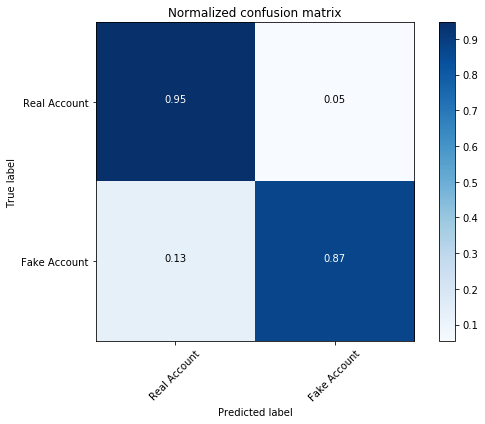

In [103]:
#Plot the confusion matrix
import itertools
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

## Repeat results for extended embeddings

In [104]:
labels=np.zeros((nodes.shape))
labels[fake_node_i]=1
print('Minority-Majority ratio = ', sum(labels==1)/len(labels))

Minority-Majority ratio =  0.013592496941688188


## The embedding data is highly imbalanced. We will under sample the majority class and then over sample the minority class

In [105]:
#Under-sample the majority class using Random-sampler
from imblearn.under_sampling import RandomUnderSampler
rus=RandomUnderSampler(sampling_strategy=0.1,random_state=42)
embeddings_us, labels_us=rus.fit_resample(embeddings_ext,labels)
print('Minority-Majority ratio = ', sum(labels_us==1)/sum(labels_us==0))

Minority-Majority ratio =  0.1


In [106]:
#Over-sample the minority class
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=0.4,random_state=42)
embeddings_os, labels_os=smote.fit_resample(embeddings_us,labels_us)
print('Minority-Majority ratio = ', sum(labels_os==1)/sum(labels_os==0))

Minority-Majority ratio =  0.4


## Split data into train and test set

In [107]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(embeddings_os,labels_os,test_size= 0.2,random_state=0)

## Create deep learning model

In [108]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from keras.models import load_model

In [111]:
# Initialize model

input_size = x_train.shape[1] # Features from X matrix

M1 = Sequential()

# Add an input layer
M1.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M1.add(Dense(128, activation='relu'))

# Add second hidden layer
M1.add(Dense(64, activation='relu'))

#Add third hidden layer
M1.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M1.add(Dense(16, activation='relu'))

# Add output layer
M1.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.adam(lr=1e-3)


M1.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=12, verbose=0, mode='min')
check_pointer=keras.callbacks.ModelCheckpoint(filepath='./best_weights_ext.hdf5',verbose=0, monitor='val_loss', mode='min', save_best_only=True)


## Train the model

In [112]:
M1.fit(x_train, y_train, batch_size=16, epochs=200, validation_split=0.2, callbacks=[check_pointer])

Train on 1792 samples, validate on 448 samples
Epoch 1/200
1792/1792 [==============================] - 2s 1ms/step - loss: 0.6116 - acc: 0.7126 - val_loss: 0.6823 - val_acc: 0.7098
Epoch 2/200
1792/1792 [==============================] - 1s 294us/step - loss: 0.5640 - acc: 0.7333 - val_loss: 0.5881 - val_acc: 0.6853
Epoch 3/200
1792/1792 [==============================] - 1s 295us/step - loss: 0.5581 - acc: 0.7305 - val_loss: 0.5614 - val_acc: 0.7232
Epoch 4/200
1792/1792 [==============================] - 1s 293us/step - loss: 0.5347 - acc: 0.7305 - val_loss: 0.6286 - val_acc: 0.7121
Epoch 5/200
1792/1792 [==============================] - 1s 304us/step - loss: 0.5249 - acc: 0.7400 - val_loss: 0.5633 - val_acc: 0.6987
Epoch 6/200
1792/1792 [==============================] - 1s 287us/step - loss: 0.5257 - acc: 0.7483 - val_loss: 0.5509 - val_acc: 0.7634
Epoch 7/200
1792/1792 [==============================] - 1s 298us/step - loss: 0.5032 - acc: 0.7640 - val_loss: 0.5336 - val_acc: 0.7

1792/1792 [==============================] - 1s 307us/step - loss: 0.0553 - acc: 0.9888 - val_loss: 0.3933 - val_acc: 0.9107
Epoch 61/200
1792/1792 [==============================] - 1s 298us/step - loss: 0.0830 - acc: 0.9788 - val_loss: 0.4010 - val_acc: 0.9040
Epoch 62/200
1792/1792 [==============================] - 1s 310us/step - loss: 0.0615 - acc: 0.9888 - val_loss: 0.4447 - val_acc: 0.9107
Epoch 63/200
1792/1792 [==============================] - 1s 310us/step - loss: 0.0802 - acc: 0.9821 - val_loss: 0.3835 - val_acc: 0.9085
Epoch 64/200
1792/1792 [==============================] - 1s 309us/step - loss: 0.0541 - acc: 0.9900 - val_loss: 0.4515 - val_acc: 0.9040
Epoch 65/200
1792/1792 [==============================] - 1s 303us/step - loss: 0.0349 - acc: 0.9972 - val_loss: 0.4697 - val_acc: 0.9241
Epoch 66/200
1792/1792 [==============================] - 1s 303us/step - loss: 0.0280 - acc: 0.9983 - val_loss: 0.5057 - val_acc: 0.9263
Epoch 67/200
1792/1792 [=======================

1792/1792 [==============================] - 1s 304us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 0.9242 - val_acc: 0.9219
Epoch 120/200
1792/1792 [==============================] - 1s 312us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 0.9251 - val_acc: 0.9219
Epoch 121/200
1792/1792 [==============================] - 1s 300us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 0.9284 - val_acc: 0.9219
Epoch 122/200
1792/1792 [==============================] - 1s 309us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 0.9295 - val_acc: 0.9219
Epoch 123/200
1792/1792 [==============================] - 1s 301us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 0.9308 - val_acc: 0.9219
Epoch 124/200
1792/1792 [==============================] - 1s 313us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 0.9334 - val_acc: 0.9219
Epoch 125/200
1792/1792 [==============================] - 1s 302us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 0.9350 - val_acc: 0.9219
Epoch 126/200
1792/1792 [================

1792/1792 [==============================] - 0s 255us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 1.0036 - val_acc: 0.9219
Epoch 179/200
1792/1792 [==============================] - 0s 258us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 1.0063 - val_acc: 0.9219
Epoch 180/200
1792/1792 [==============================] - 0s 256us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 1.0084 - val_acc: 0.9219
Epoch 181/200
1792/1792 [==============================] - 0s 256us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 1.0089 - val_acc: 0.9219
Epoch 182/200
1792/1792 [==============================] - 0s 263us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 1.0097 - val_acc: 0.9219
Epoch 183/200
1792/1792 [==============================] - 0s 255us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 1.0083 - val_acc: 0.9219
Epoch 184/200
1792/1792 [==============================] - 0s 263us/step - loss: 0.0267 - acc: 0.9983 - val_loss: 1.0107 - val_acc: 0.9219
Epoch 185/200
1792/1792 [================

## Test the model and look at some results

In [113]:
M1=load_model('best_weights_ext.hdf5')
y_pred = M1.predict(x_test)

# Print classfication report
target_names = ['Real Account','Fake Account']
confusion_matrix = cm(y_test, np.round(y_pred))
print("Classification Report")
print(classification_report(y_test, np.round(y_pred), target_names=target_names))

Classification Report
              precision    recall  f1-score   support

Real Account       0.93      0.91      0.92       389
Fake Account       0.81      0.84      0.82       171

    accuracy                           0.89       560
   macro avg       0.87      0.87      0.87       560
weighted avg       0.89      0.89      0.89       560



Normalized confusion matrix
[[0.9125964  0.0874036 ]
 [0.16374269 0.83625731]]


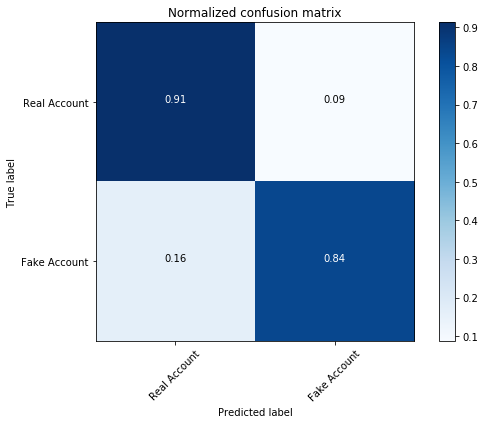

In [114]:
#Plot the confusion matrix
import itertools
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')